In [1]:
import os
import sys

In [2]:
#sys.path.insert(0, '/Users/marusy/Programming/another-fem-framework/')
sys.path.insert(0, '/home/lshtanko/Programming/another-fem-framework/')
#sys.path.insert(0, '/Users/leonshting/Programming/Schlumberger/fem-framework/')

In [3]:
import numpy as np
from interpolant.cell_to_points import Cell2PointsConverter
from interpolant.strict import StrictSolve
from interpolant.opt import OptSolve
from common.helpers import *
from interpolant.helpers import *
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
np.set_printoptions(linewidth=500)

In [27]:
c2p = Cell2PointsConverter(orders=[[3],[3,3]])

In [28]:
c2p.weights[0][0].sum()

1.0

In [32]:
strict_solve = StrictSolve(points=c2p.get_points(), weights=c2p.get_diag_weights(), verbose=True)

In [33]:
strict_solve.fit_strict(max_power=strict_solve.get_max_pow(risky=True), method='svd', options={'eps':1e-6})

Number of equations: 33
Number of degrees of freedom: 28
Strictly stitched_power: 2
Start solving strict part
[False False False False False False False False False False False False False False False False False False False False False False False False  True  True  True  True]
Nullspace shape: (28, 4)
End solving strict part
NullspaceRank: 4


In [34]:
interps = strict_solve.get_interpolants()
wgths = strict_solve.get_weight_matrices()

In [35]:
opt_solve = OptSolve(matrices=interps,
                     points=c2p.get_points(),
                     strict_power=strict_solve.get_max_pow(unrisky=False),
                     weights_matrices=wgths,
                     verbose=True
                    )

In [36]:
opt_solve.fit_opt(constraints=True, tr_fun_option='chebyshev', orders_forwards=2)

Results are saved, get your interploants in I_rl and I_lr fields or restart with higher tolerance


In [ ]:
opt_solve.restart_opt(tolerance=1e-3)

In [37]:
I_rl = np.array(opt_solve.I_rl_subbed).astype(np.float64)
I_lr = np.array(opt_solve.I_lr_subbed).astype(np.float64)

In [41]:
tr_f = np.vectorize(lambda x: x*(x-1))

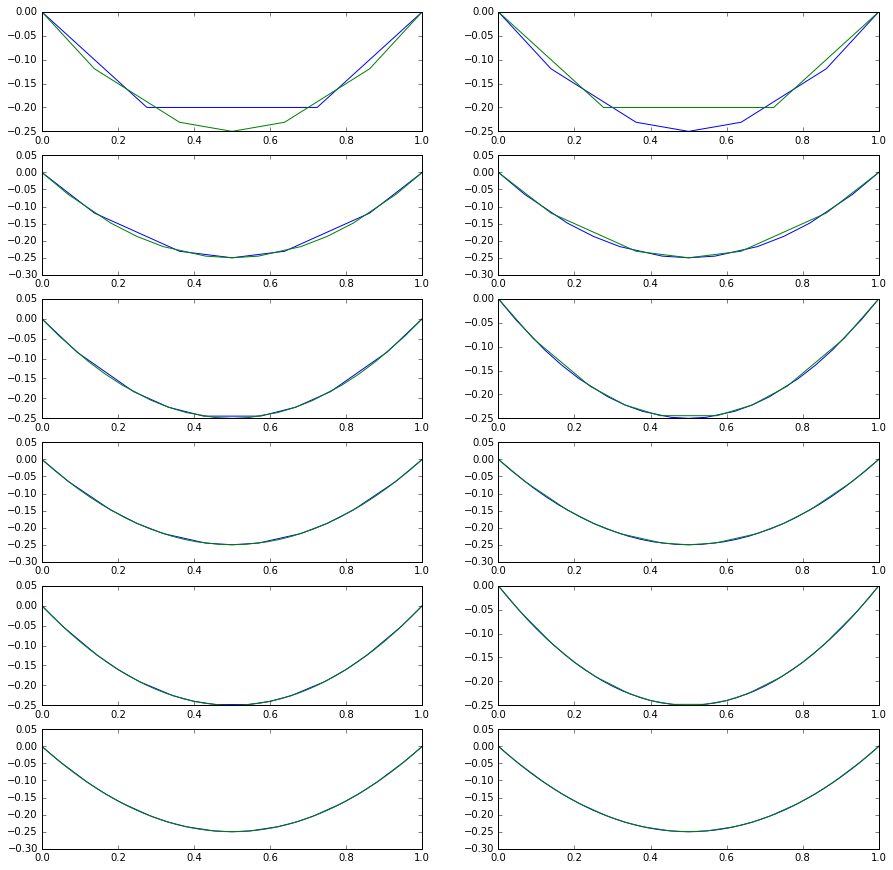

In [42]:
eps_l, eps_r = convergence_test(I_lr=new_int1,
                                I_rl=new_int2,
                                p_l=opt_solve.points[0],
                                p_r=opt_solve.points[1],
                                init_size=(0,1),
                                tr_f=tr_f,
                                weights=[np.array(strict_solve.W_l), np.array(strict_solve.W_r)],
                                div_lim=7)

In [ ]:
explosion_test(I_lr=I_lr,
               I_rl=I_rl,
               p_l=opt_solve.points[0],
               p_r=opt_solve.points[1],
               tr_f=tr_f,
               reps=3)

In [ ]:
plt.semilogy(range(len(eps_l)), eps_l)
plt.semilogy(range(len(eps_r)), eps_r)
plt.semilogy(np.linspace(0, len(eps_r)), float(eps_r[0])*np.exp(-np.linspace(0, len(eps_r))))
plt.semilogy(np.linspace(0, len(eps_r)), float(eps_r[0])*np.exp(-2*np.linspace(0, len(eps_r))))

In [40]:
np.linalg.eigvals(np.dot(new_int1, new_int2))

array([  9.89035006e-01,   1.00003140e+00,   1.00000395e+00,   9.99997524e-01,  -5.22507041e-17,   8.60941720e-17,   8.07622567e-18])

In [ ]:
np.linalg.eigvals(np.dot(I_lr, I_rl))

In [38]:
new_int1 = (I_lr + I_lr[::-1,::-1])/2

In [39]:
new_int2 = (I_rl + I_rl[::-1, ::-1])/2

In [43]:
new_int1

array([[ 1.17504922, -0.39140656,  0.39140656, -0.17504922],
       [ 0.29337173,  0.90301192, -0.30752192,  0.11113827],
       [-0.08065374,  0.8938717 ,  0.2606383 , -0.07385626],
       [-0.125     ,  0.625     ,  0.625     , -0.125     ],
       [-0.07385626,  0.2606383 ,  0.8938717 , -0.08065374],
       [ 0.11113827, -0.30752192,  0.90301192,  0.29337173],
       [-0.17504922,  0.39140656, -0.39140656,  1.17504922]])

In [44]:
new_int2

array([[ 0.58752961,  0.73341258, -0.20163508, -0.125     , -0.18463492,  0.27786242, -0.08752961],
       [-0.03914037,  0.45152847,  0.44695071,  0.125     ,  0.13029929, -0.15377847,  0.03914037],
       [ 0.03914037, -0.15377847,  0.13029929,  0.125     ,  0.44695071,  0.45152847, -0.03914037],
       [-0.08752961,  0.27786242, -0.18463492, -0.125     , -0.20163508,  0.73341258,  0.58752961]])

In [ ]:
new_int1 = np.array([[ 1.   ,  0.   ,  0.   ],
       [ 0.375,  0.75 , -0.125],
       [ 0.   ,  1.   ,  0.   ],
       [-0.125,  0.75 ,  0.375],
       [ 0.   ,  0.   ,  1.   ]])



In [ ]:
new_int2 = np.dot(np.dot(c2p.get_diag_weights()[1], new_int1), np.linalg.inv(c2p.get_diag_weights()[0])).T

In [ ]:
new_int1

In [ ]:
new_int2

In [ ]:
new_int1 = normalize((new_int1 + new_int2.T)/2)

In [ ]:
def normalize(v):
    norm=np.linalg.norm(v, ord=1, axis=-1)
    return (v.T/norm).T

In [ ]:
from common.polynom_factory import polynom_factory

def get_href_constrain_matrix(order, inversed=False, distribution='uniform'):
    glob_func_on_loc_mesh = np.zeros((order+1, order+1))
    funcs_prim, glob_grid = polynom_factory(dim=1, order=order,size=(0,2), distribution=distribution)
    funcs, local_grid = polynom_factory(dim=1, order=order,size=(0,1), distribution=distribution)
    for num1, i in enumerate(local_grid):
        for num2, prim_f in enumerate(funcs_prim):
            glob_func_on_loc_mesh[num1, num2] = prim_f.subs({'x_1':i[0]})
    if(inversed):
        return np.linalg.inv(glob_func_on_loc_mesh)
    else:
        return glob_func_on_loc_mesh

In [ ]:
a = get_href_constrain_matrix(distribution='globatto', order=5)
b = np.vstack((a, a[::-1,::-1][1:]))

In [ ]:
a[::-1, ::-1][1:]

In [ ]:
a[1:][::-1, ::-1]

In [ ]:
b

In [ ]:
a

In [ ]:
import sympy

In [ ]:
opt_solve.I_lr.shape

In [ ]:
opt_solve.I_rl.shape

In [ ]:
b.shape

In [ ]:
eq_matrix = opt_solve.I_lr - sympy.Matrix(b)

In [ ]:
eqs_list = []
for i,j in itertools.product(*[range(i) for i in eq_matrix.shape]):
    eqs_list.append(eq_matrix[i,j])

In [ ]:
A,b = sympy.linear_eq_to_matrix(eqs_list, *eq_matrix.free_symbols)

In [ ]:
A_n = np.array(A)
b_n = np.array(b)

In [ ]:
A_n.shape

In [ ]:
b_n.shape

In [ ]:
sol = np.linalg.lstsq(a=A_n, b=b_n)[0]

In [ ]:
subbed = opt_solve.I_lr.subs({i:j for i,j in zip(opt_solve.I_lr.free_symbols, sol)}) 

In [ ]:
subbed

In [ ]:
log = np.linalg.lstsq(a=A_n, b=b_n)

In [ ]:
log

In [ ]:
sol

In [ ]:
a = [8,7,6,5,4,3,2]

In [ ]:
b = "1 2 3 4 5 6 7 8 9".split(" ")

In [ ]:
c = [b[i] for i in a]

In [ ]:
c

In [ ]:
b